In [23]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

In [24]:
# 独热编码
def encode_onehot(labels):
    # The classes must be sorted before encoding to enable static class encoding.
    # In other words, make sure the first class always maps to index 0.
    classes = sorted(list(set(labels)))  # set() 函数创建一个无序不重复元素集
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in # identity创建方矩阵
                     enumerate(classes)}  # 字典 key为label的值，value为矩阵的每一行
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)  # get函数得到字典key对应的value
    
    return labels_onehot

In [25]:
def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)


def normalize_features(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [26]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels) # 使用type_as(tesnor)将张量转换为给定类型的张量。
    correct = preds.eq(labels).double()  # 记录等于preds的label eq:equal
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):    # 把一个sparse matrix转为torch稀疏张量
    """
    numpy中的ndarray转化成pytorch中的tensor : torch.from_numpy()
    pytorch中的tensor转化成numpy中的ndarray : numpy()
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    # 不懂的可以去看看COO性稀疏矩阵的结构
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [27]:
# 数据加载
def load_data(path="./cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))
    """
    # content file的每一行的格式为: <paper_id> <word_attributes>+ <class_label>
    #    分别对应 0, 1:-1, -1
    # feature为第二列到倒数第二列,labels为最后一列
    """
    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)

    # build graph
    """
    # cites file的每一行格式为:  <cited paper ID>  <citing paper ID>
    # 根据前面的contents与这里的cites创建图,算出edges矩阵与adj 矩阵
    """  
    # 由于文件中节点并非是按顺序排列的，因此建立一个编号为0-(node_size-1)的哈希表idx_map，
    # 哈希表中每一项为id: number，即节点id对应的编号为number
    idx_map = {j: i for i, j in enumerate(idx)}   
    # edges_unordered为直接从边表文件中直接读取的结果，是一个(edge_num, 2)的数组，每一行表示一条边两个端点的idx
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset), dtype=np.int32)
    # 边的edges_unordered中存储的是端点id，要将每一项的id换成编号。
    # 在idx_map中以idx作为键查找得到对应节点的编号，reshape成与edges_unordered形状一样的数组
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)

    # 根据coo矩阵性质，这一段的作用就是，网络有多少条边，邻接矩阵就有多少个1，
    # 所以先创建一个长度为edge_num的全1数组，每个1的填充位置就是一条边中两个端点的编号，
    # 即edges[:, 0], edges[:, 1]，矩阵的形状为(node_size, node_size)。
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)


    # build symmetric adjacency matrix
    # 对于无向图，邻接矩阵是对称的。上一步得到的adj是按有向图构建的，转换成无向图的邻接矩阵需要扩充成对称矩阵
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # 标准化特征值和邻接矩阵
    features = normalize_features(features)
    adj = normalize_adj(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    # adj = sparse_mx_to_torch_sparse_tensor(adj)   # 邻接矩阵转为tensor处理
    adj = torch.FloatTensor(np.array(adj.todense()))
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

In [28]:
adj, features, labels, idx_train, idx_val, idx_test = load_data()

Loading cora dataset...


In [29]:
print('adj.shape:', adj.shape)
print('features.shape:', features.shape)
print('labels.shape:', labels.shape)
print('idx_train.shape:', idx_train.shape)
print('idx_val.shape:', idx_val.shape)
print('idx_test.shape:', idx_test.shape)

adj.shape: torch.Size([2708, 2708])
features.shape: torch.Size([2708, 1433])
labels.shape: torch.Size([2708])
idx_train.shape: torch.Size([140])
idx_val.shape: torch.Size([300])
idx_test.shape: torch.Size([1000])


### GAT model

In [30]:
class GATLayer(nn.Module):

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.in_features = in_features  # 节点向量的特征维度
        self.out_features = out_features  # 经过GAT之后的特征维度
        self.dropout = dropout  # dropout参数
        self.alpha = alpha  # leakyReLU的参数
        self.concat = concat

        # 定义可训练参数，即论文中的W和a
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features))) #建立都是0的矩阵，大小为（输入维度，输出维度）
        nn.init.xavier_uniform_(self.W.data, gain=1.414)  # xavier初始化

        self.a = nn.Parameter(torch.zeros(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)  # xavier初始化
        #print(self.a.shape)  torch.Size([16, 1])

        # 定义leakyReLU激活函数
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input_h, adj):
        """
        input_h:  [N, in_features]
        adj: 图的邻接矩阵 维度[N, N] 
        """
        # self.W [in_features,out_features]
        # input_h × self.W  ->  [N, out_features]

        h = torch.mm(input_h, self.W)  # [N, out_features]
        #print(h.shape)  torch.Size([2708, 8]) 8是label的个数

        N = h.size()[0]  # N 图的节点数
        #print(N)  2708 nodes的个数

        input_concat = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1). \
            view(N, -1, 2 * self.out_features)# [N, N, 2*out_features]
        #print(input_concat.shape)  torch.Size([2708, 2708, 16])

        e = self.leakyrelu(torch.matmul(input_concat, self.a).squeeze(2))  #即论文里的eij
        # [N, N, 1] => [N, N] 图注意力的相关系数（未归一化）
        #[2708, 2708, 16]与[16, 1]相乘再除去维数为1的维度，故其维度为[2708,2708],与领接矩阵adj的维度一样

        zero_vec = -1e12 * torch.ones_like(e)  # 将没有连接的边置为负无穷

        attention = torch.where(adj > 0, e, zero_vec)  # [N, N]
        # 表示如果邻接矩阵元素大于0时，则两个节点有连接，该位置的注意力系数保留，
        # 否则需要mask并置为非常小的值，原因是softmax的时候这个最小值会不考虑。

        attention = F.softmax(attention, dim=1)  # softmax形状保持不变 [N, N]，得到归一化的注意力权重！

        attention = F.dropout(attention, self.dropout, training=self.training)  # dropout，防止过拟合

        output_h = torch.matmul(attention, h)  # [N, N].[N, out_features] => [N, out_features]
        # 得到由周围节点通过注意力权重进行更新的表示

        if self.concat:
            return F.elu(output_h)
        else:
            return output_h

In [31]:
class MyGAT(nn.Module):
    def __init__(self, input_feature_size, output_size, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(MyGAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GATLayer(input_feature_size, output_size, dropout=dropout, alpha=alpha, concat = True)
                           for _ in range(nheads)]  #输入到隐藏层
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GATLayer(output_size * nheads, nclass, dropout=dropout, alpha=alpha, concat = False) #multi-head 隐藏层到输出

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        
        return F.log_softmax(x, dim=1)

In [32]:
import argparse
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False, help='Disables CUDA training.')
# parser.add_argument('--fastmode', action='store_true', default=False, help='Validate during training pass.')
parser.add_argument('--model', type=str, default="gat", help='which gnn model use')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=30, help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=1e-4, help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=8, help='Number of hidden units.')
parser.add_argument('--nb_heads', type=int, default=8, help='Number of head attentions.')
parser.add_argument('--dropout', type=float, default=0.6, help='Dropout rate (1 - keep probability).')
parser.add_argument('--alpha', type=float, default=0.2, help='Alpha for the leaky_relu.')
parser.add_argument('--patience', type=int, default=100, help='Patience')
# parser.add_argument('--config', type=str, default='./experiments.conf')   # 获取的一些配置文件
#args = parser.parse_args()                                               # pychram 中使用
args = parser.parse_known_args()[0]                                       # jupyter 中使用
args

Namespace(no_cuda=False, model='gat', seed=42, epochs=30, lr=0.01, weight_decay=0.0001, hidden=8, nb_heads=8, dropout=0.6, alpha=0.2, patience=100)

In [33]:
import random
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

In [34]:
model = MyGAT(input_feature_size=1433,
            output_size=8,
            nclass=7,
            dropout=0.6,
            nheads=8,
            alpha=0.2)

In [35]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr,
                       weight_decay=args.weight_decay)

In [36]:
def train(epochs):

    loss_history = []
    val_acc_history = []
    model.train()
    
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(features, adj)
        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        optimizer.step()

        loss_val = F.nll_loss(output[idx_val], labels[idx_val])
        acc_val = accuracy(output[idx_val], labels[idx_val])
        
        # 记录训练过程中损失值和准确率的变化，用于画图
        loss_history.append(loss_train.item())
        val_acc_history.append(acc_val.item())

        if (epoch % 10 == 0):
            print("Epoch: {}".format(epoch + 1),
                 "loss_train: {:.4f}".format(loss_train.item()),
                 "acc_train: {:.4f}".format(acc_train.item()),
                 "loss_val: {:.4f}".format(loss_val.item()),
                 "acc_val: {:.4f}".format(acc_val.item()))
    return loss_history, val_acc_history

In [37]:
loss_history, val_acc_history = train(args.epochs)

Epoch: 1 loss_train: 1.9413 acc_train: 0.1429 loss_val: 1.9450 acc_val: 0.1433
Epoch: 11 loss_train: 1.7225 acc_train: 0.5000 loss_val: 1.7511 acc_val: 0.5000
Epoch: 21 loss_train: 1.3911 acc_train: 0.6000 loss_val: 1.4881 acc_val: 0.5600


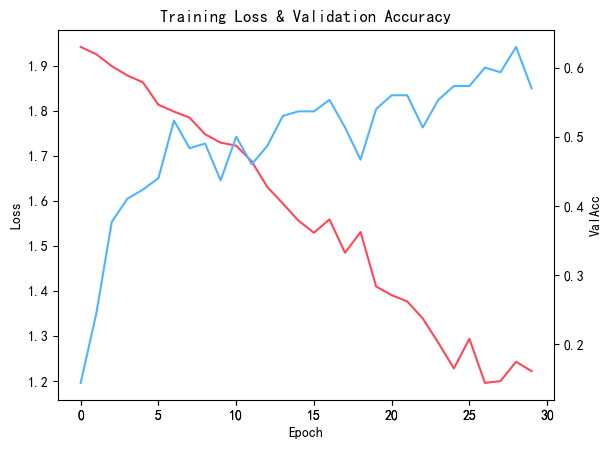

In [38]:
# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    # 坐标系ax1画曲线1
    ax1 = fig.add_subplot(111)  # 指的是将plot界面分成1行1列，此子图占据从左到右从上到下的1位置
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)  # c为颜色
    plt.ylabel('Loss')
    
    # 坐标系ax2画曲线2
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)  # 其本质就是添加坐标系，设置共享ax1的x轴，ax2背景透明
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()  # 开启右边的y坐标
    
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()
 
plot_loss_with_acc(loss_history, val_acc_history)

In [39]:
# test    
def test():
    model.eval()
    with torch.no_grad():  # 显著减少显存占用
        output = model(features, adj)
        pred = output.max(1)[1].type_as(labels)
        loss_test = F.nll_loss(output[idx_test], labels[idx_test])
        acc_test = accuracy(output[idx_test], labels[idx_test])
        print("Test set results:",
            "loss= {:.4f}".format(loss_test.item()),
            "accuracy= {:.4f}".format(acc_test.item()))
    
    return output, pred

In [40]:
# Testing
output, test_label = test()

Test set results: loss= 1.3110 accuracy= 0.6820


In [41]:
output.shape

torch.Size([2708, 7])

### 结果降维可视化

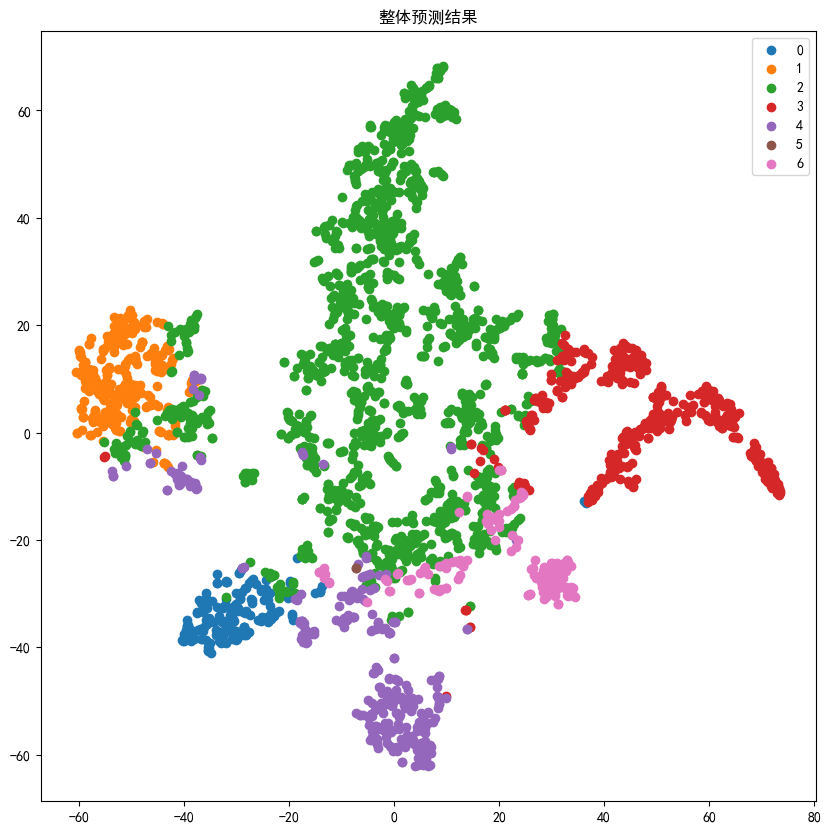

In [42]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
out = tsne.fit_transform(output)

plt.figure(figsize=(10,10))
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.title("整体预测结果")
plt.legend()
plt.show()

预测总数: 2708
预测成功数: 1830
预测失败数: 878
准确率: 0.6757754800590842


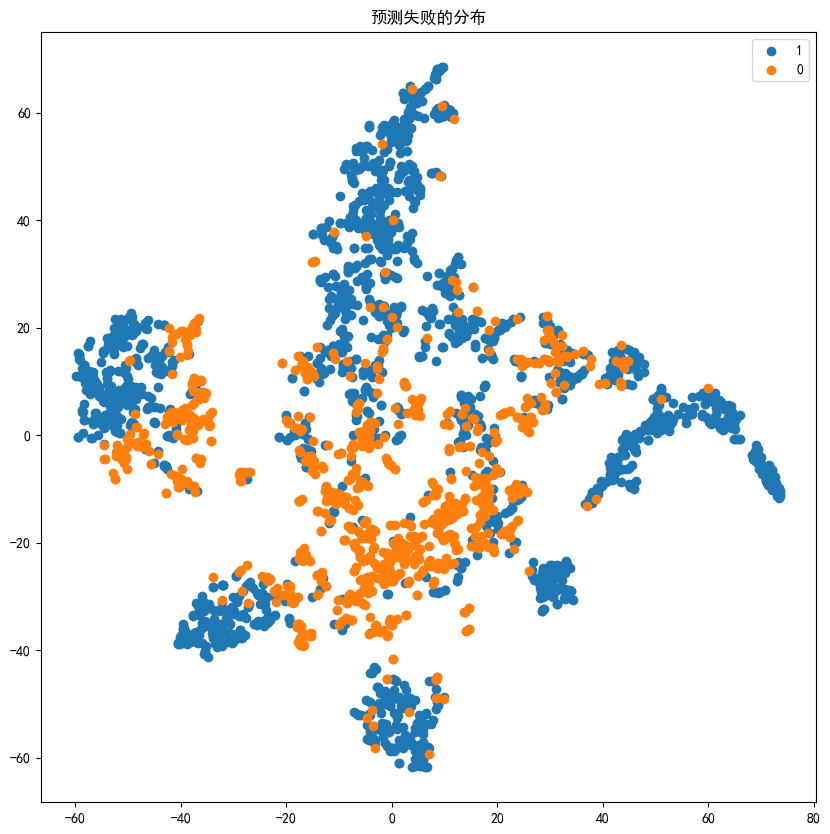

In [43]:
out = tsne.fit_transform(output)

plt.figure(figsize=(10,10))

indices = labels == test_label 
x, y = out[indices].T
plt.scatter(x, y, label=str(1))
print('预测总数:', len(indices))
print('预测成功数:', int(indices.sum()))

indices = labels != test_label 
x, y = out[indices].T
plt.scatter(x, y, label=str(0))
print('预测失败数:', int(indices.sum()))
print('准确率:', (len(indices)-int(indices.sum()))/len(indices))

plt.title("预测失败的分布")
plt.legend()
plt.show()

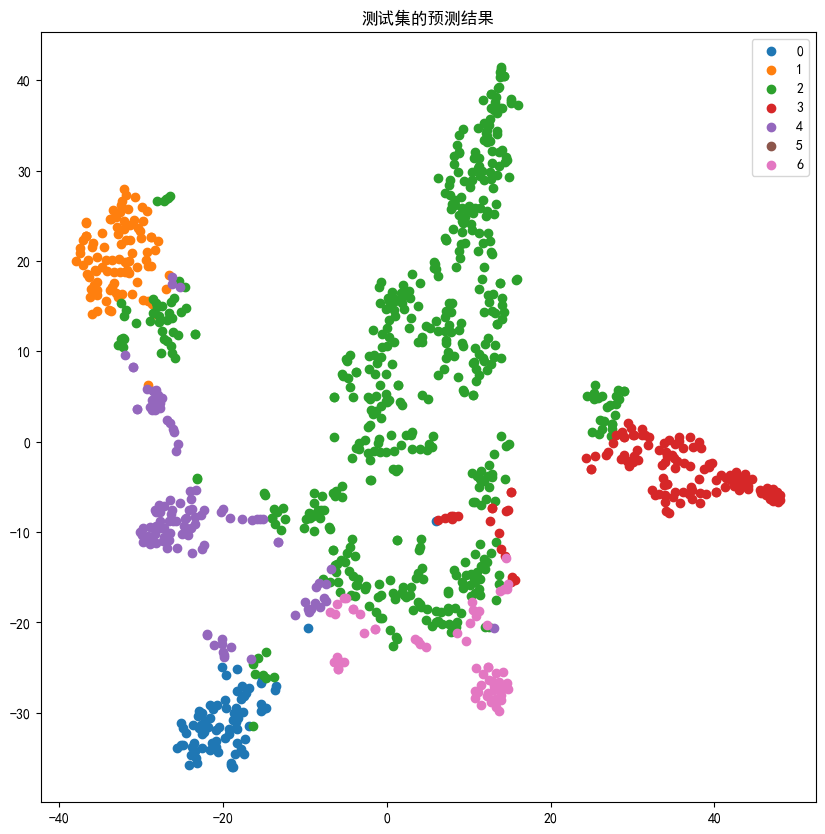

In [44]:
out = tsne.fit_transform(output[idx_test])

plt.figure(figsize=(10,10))
for i in range(7):
    indices = test_label[idx_test] == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))

plt.title("测试集的预测结果")
plt.legend()
plt.show()